# Check characteristics of participants

In [1]:
import os
os.getcwd()
os.chdir('/orcd/home/002/baesuj/20.490_Deep_Learning_Biology')

In [2]:
import pandas as pd

sampled_df = pd.read_csv("SJBae/sampled_metadata_contig_ACBI_2x.csv")

## Participants per group

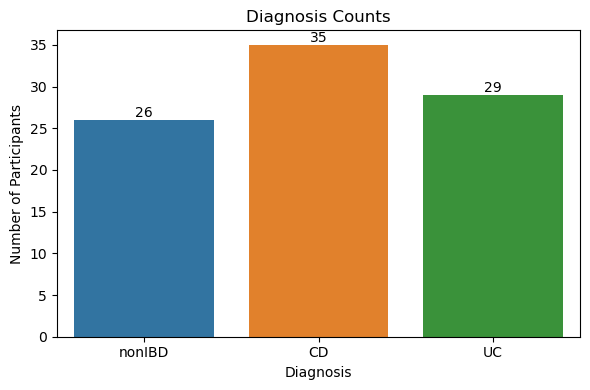

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Drop duplicates to get one row per participant
sampled_df_unique = sampled_df.drop_duplicates(subset="Participant ID")


# Specify desired order
diagnosis_order = ["nonIBD", "CD", "UC"]

# Step 3: Plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=sampled_df_unique, x="diagnosis", order=diagnosis_order)
plt.title("Diagnosis Counts")
plt.xlabel("Diagnosis")
plt.ylabel("Number of Participants")

# Step 4: Add value labels above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(str(count), 
                (p.get_x() + p.get_width() / 2., count), 
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Medical characteristics per group

In [4]:
# Step 1: Drop duplicate participants
sampled_df_unique = sampled_df.drop_duplicates(subset="Participant ID")

# Step 2: Summary metadata per diagnosis
summary = sampled_df_unique.groupby("diagnosis").agg({
    "Participant ID": "count",
    "consent_age": ["mean", "std"],
    "Age at diagnosis": ["mean", "std"],
    "sex": lambda x: x.value_counts().to_dict(),
    "Antibiotics": lambda x: x.value_counts().to_dict(),
    "Chemotherapy": lambda x: x.value_counts().to_dict(),
    "Immunosuppressants (e.g. oral corticosteroids)": lambda x: x.value_counts().to_dict(),
    "6) Have you ever had bowel surgery?": lambda x: x.value_counts().to_dict()
})

# Flatten multi-index columns
summary.columns = [
    "Total Participants",
    "Mean Age", "Std Age",
    "Mean Age at Diagnosis", "Std Age at Diagnosis",
    "Sex Distribution", "Antibiotics", "Chemotherapy",
    "Immunosuppressants", "Bowel Surgery"
]

# Round numeric columns
numeric_cols = ["Mean Age", "Std Age", "Mean Age at Diagnosis", "Std Age at Diagnosis"]
summary[numeric_cols] = summary[numeric_cols].round(2)

# Transpose
summary_transposed = summary.T
summary_transposed.columns.name = None

# Step 3a: Site-level counts per diagnosis with total row
sites_pivot = sampled_df_unique.pivot_table(
    index="site_name",
    columns="diagnosis",
    values="Participant ID",
    aggfunc="count",
    fill_value=0
)
sites_row = pd.DataFrame(sites_pivot.sum()).T
sites_row.index = ["Sites"]
sites = pd.concat([sites_row, sites_pivot])
sites.loc["Sites"] = ""
sites = sites[summary_transposed.columns]

# Step 3b: Education Level per diagnosis with header
education_pivot = sampled_df_unique.groupby("diagnosis")["Education Level"].value_counts().unstack(fill_value=0).T
education_pivot.index.name = "Education Level"
edu_row = pd.DataFrame(["" for _ in range(education_pivot.shape[1])], index=education_pivot.columns).T
edu_row.index = ["Education"]
education = pd.concat([edu_row, education_pivot])
education = education[summary_transposed.columns]

# Step 3c: race
race_pivot = sampled_df_unique.groupby("diagnosis")["race"].value_counts().unstack(fill_value=0).T
race_pivot.index.name = "Race/Ethnicity"
race_row = pd.DataFrame(["" for _ in range(race_pivot.shape[1])], index=race_pivot.columns).T
race_row.index = ["Race/Ethnicity"]
race = pd.concat([race_row, race_pivot])
race = race[summary_transposed.columns]

# Step 4: Combine all into final table
combined = pd.concat([summary_transposed, sites, education, race])

# Show the final combined table
combined


,CD,UC,nonIBD
Total Participants,35,29,26
Mean Age,19.63,29.21,29.65
Std Age,12.32,17.64,20.45
Mean Age at Diagnosis,17.76,23.48,NaN
Std Age at Diagnosis,7.98,14.61,NaN
Sex Distribution,"{'Male': 20, 'Female': 15}","{'Female': 17, 'Male': 12}","{'Male': 15, 'Female': 11}"
Antibiotics,{'No': 35},{'No': 29},{'No': 26}
Chemotherapy,{'No': 35},{'No': 29},{'No': 26}
Immunosuppressants,{'No': 35},{'No': 29},{'No': 26}
Bowel Surgery,{'No': 31},{'No': 26},{'No': 26}


In [5]:
# First, make sure the columns are standardized
cols = ["Antibiotics", "Chemotherapy", "Immunosuppressants (e.g. oral corticosteroids)", "6) Have you ever had bowel surgery?"]

# Create a binary DataFrame where 1 = 'Yes', 0 = 'No'
binary_df = sampled_df[cols].applymap(lambda x: 1 if x == "Yes" else 0)

# Add a column to show how many categories each participant said 'Yes' to
binary_df["Total_Yes"] = binary_df.sum(axis=1)

# Show how many participants fall into each combination
overlap_counts = binary_df.value_counts().sort_index()

# Optional: reset index for easier viewing
overlap_summary = overlap_counts.reset_index(name="Count")
print(overlap_summary)


   Antibiotics  Chemotherapy  Immunosuppressants (e.g. oral corticosteroids)  \
0            0             0                                               0   

   6) Have you ever had bowel surgery?  Total_Yes  Count  
0                                    0          0    180  


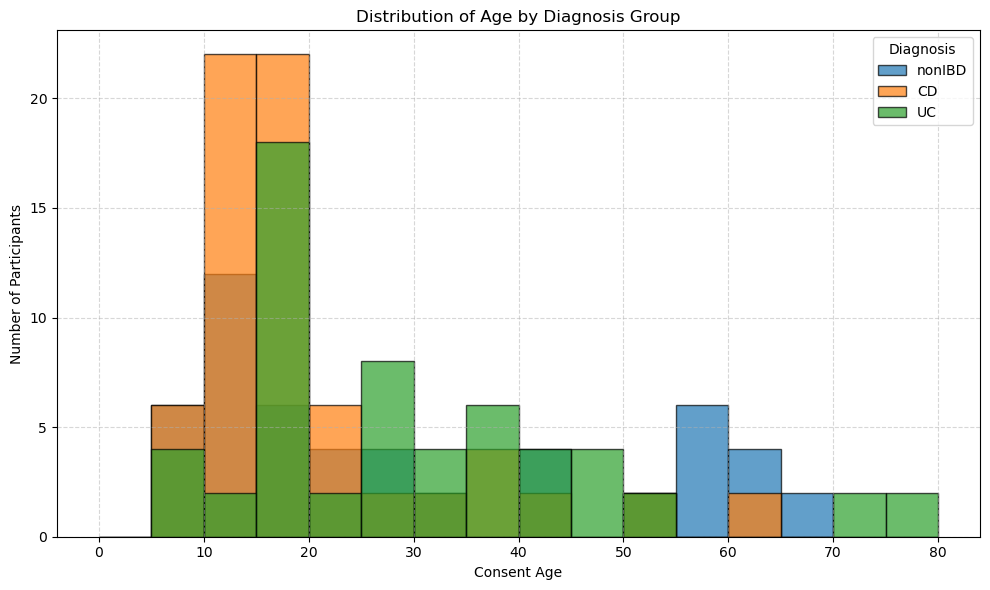

In [6]:
import matplotlib.pyplot as plt

# Filter only necessary columns and drop missing ages
age_df = sampled_df[["consent_age", "diagnosis"]].dropna()

# Define diagnosis groups and colors
groups = ["nonIBD", "CD", "UC"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green

# Plot histograms
plt.figure(figsize=(10, 6))
bins = range(0, int(age_df["consent_age"].max()) + 5, 5)  # 5-year bins

for group, color in zip(groups, colors):
    plt.hist(
        age_df[age_df["diagnosis"] == group]["consent_age"],
        bins=bins,
        alpha=0.7,
        label=group,
        color=color,
        edgecolor="black"
    )

plt.xlabel("Consent Age")
plt.ylabel("Number of Participants")
plt.title("Distribution of Age by Diagnosis Group")
plt.legend(title="Diagnosis")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("age_histogram.png")
plt.show()


## Contig quality check

In [7]:
# Step 1: DO NOT Drop duplicate participants

# Step 2: Summary metadata per diagnosis
summary = sampled_df.groupby("diagnosis").agg({
    "External ID": "count",
    "contig_count": ["mean", "std"],
    "largest_contig": ["mean", "std"],
    "total_length": ["mean", "std"],
    "gc_content": ["mean", "std"],
    "N50": ["mean", "std"],
    "L50": ["mean", "std"],

})

# Flatten multi-index columns
summary.columns = [
    "Total samples",
    "contig_count (Mean)", "contig_count (Std)",
    "largest_contig (Mean)", "largest_contig (Std)",
    "total_length (Mean)", "total_length (Std)",
    "gc_content (Mean)", "gc_content (Std)",
    "N50 (Mean)", "N50 (Std)",
    "L50 (Mean)", "L50 (Std)"
]

# Round numeric columns
summary = summary.round(2)

# Transpose
summary_transposed = summary.T
summary_transposed.columns.name = None

# Show the final combined table
summary_transposed


,CD,UC,nonIBD
Total samples,70.00,58.00,52.00
contig_count (Mean),40914.26,42243.91,54331.02
contig_count (Std),14821.17,17446.69,20951.49
largest_contig (Mean),308911.57,263273.45,299265.56
largest_contig (Std),144576.09,128189.08,147698.33
total_length (Mean),53080645.70,52602542.84,61432032.77
total_length (Std),15359080.21,19826704.08,18154653.93
gc_content (Mean),46.33,45.93,46.88
gc_content (Std),1.27,1.26,1.27
N50 (Mean),4631.89,4221.71,4424.42


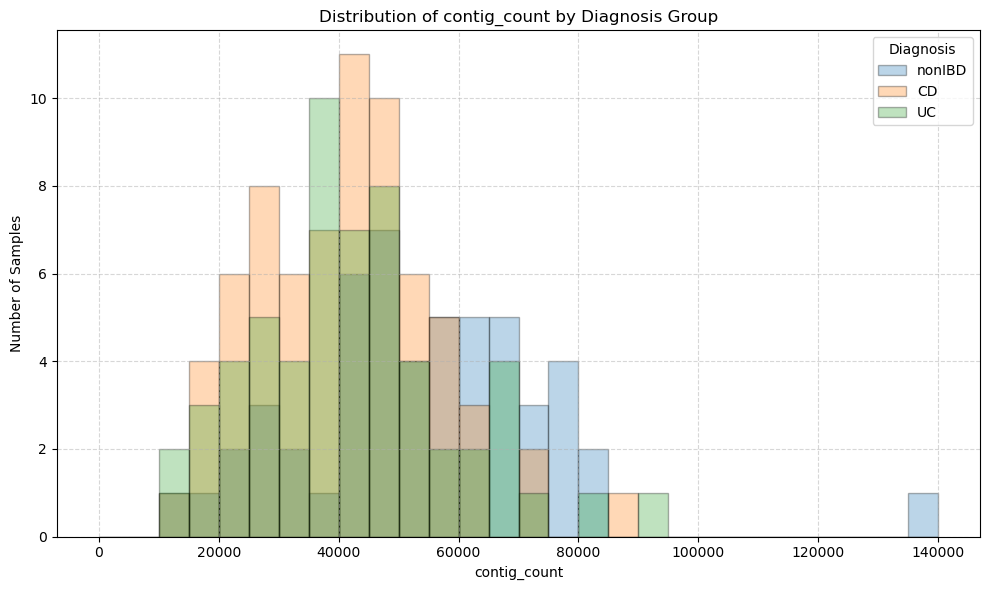

In [8]:
import matplotlib.pyplot as plt

# Filter only necessary columns and drop missing ages
contig_count_df = sampled_df[["contig_count", "diagnosis"]].dropna()

# Plot histograms
plt.figure(figsize=(10, 6))
bins = range(0, int(contig_count_df["contig_count"].max()) + 5000, 5000) 

for group, color in zip(groups, colors):
    plt.hist(
        contig_count_df[contig_count_df["diagnosis"] == group]["contig_count"],
        bins=bins,
        alpha=0.3,
        label=group,
        color=color,
        edgecolor="black"
    )

plt.xlabel("contig_count")
plt.ylabel("Number of Samples")
plt.title("Distribution of contig_count by Diagnosis Group")
plt.legend(title="Diagnosis")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("contig_count_histogram.png")
plt.show()
